In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from os import listdir
from os.path import isfile, join
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import time
import torch.linalg as lg
from scipy.interpolate import LSQUnivariateSpline

In [3]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [4]:
class FeatureTransformation(nn.Module):
    def __init__(self, num_features, hidden_layer):
        super(FeatureTransformation, self).__init__()
        
        self.feed_forward = nn.Sequential(
                        nn.Linear(num_features, hidden_layer),
                        nn.Tanh()
        )
    
    #embed inputs into a hidden_layer dimensional embedding space
    def forward(self, z):
        z = self.feed_forward(z)
        return z 

In [5]:
class ForgetGate(nn.Module):
    def __init__(self, hidden_layer):
        super(ForgetGate, self).__init__()
        
        self.linear1 = nn.Linear(hidden_layer, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, hidden_layer)
        self.sigmoid = nn.Sigmoid()
        
    #runs the forget gate of an LSTM network   
    def forward(self, h_tminus1, z_t):
        zt = self.linear1(z_t)
        htminus1 = self.linear2(h_tminus1)
        sum_zh = (zt + htminus1)
        ft = self.sigmoid(sum_zh)
        return ft 

In [6]:
class InputGate(nn.Module):
    def __init__(self, hidden_layer):
        super(InputGate, self).__init__()
        
        self.linear1 = nn.Linear(hidden_layer, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, hidden_layer)
        self.linear3 = nn.Linear(hidden_layer, hidden_layer)
        self.linear4 = nn.Linear(hidden_layer, hidden_layer)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
    #runs the input gate of an LSTM network  
    def forward(self, h_tminus1, z_t):
        zt_1 = self.linear1(z_t)
        htminus1_1 = self.linear2(h_tminus1)
        sum_zh_1 = zt_1 + htminus1_1
        it1 = self.sigmoid(sum_zh_1)

        zt_2 = self.linear3(z_t)
        htminus1_2 = self.linear4(h_tminus1)
        sum_zh_2 = zt_2 + htminus1_2
        it2 = self.tanh(sum_zh_2)

        out = it1*it2
        return out 

In [7]:
class OutputGate(nn.Module):
    def __init__(self, hidden_layer):
        super(OutputGate, self).__init__()
        
        self.linear1 = nn.Linear(hidden_layer, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, hidden_layer)
        self.sigmoid = nn.Sigmoid()
    
    #runs the output gate of an LSTM network  
    def forward(self, h_tminus1, z_t):
        zt = self.linear1(z_t)
        htminus1 = self.linear2(h_tminus1)
        sum_zh = zt + htminus1
        ot = self.sigmoid(sum_zh)
        return ot 

In [8]:
class LSTMCell(nn.Module):
    def __init__(self, hidden_layer):
        super(LSTMCell, self).__init__()
        
        self.forget_gate = ForgetGate(hidden_layer)
        self.input_gate = InputGate(hidden_layer)
        self.output_gate = OutputGate(hidden_layer)
        self.tanh = nn.Tanh()
    
    #runs 1 LSTM cell
    def forward(self, h_tminus1, c_tminus1, z_t):
        ft = self.forget_gate(h_tminus1, z_t)
        it = self.input_gate(h_tminus1, z_t)
        ot = self.output_gate(h_tminus1, z_t)
        c_t = ft*c_tminus1 + it
        tanc_t = self.tanh(c_t)
        h_t = ot * tanc_t
        return h_t, c_t 

In [9]:
class LSTM(nn.Module):
    def __init__(self, num_features, hidden_layer):
        super(LSTM, self).__init__()
        
        self.feature_transformation = FeatureTransformation(num_features, hidden_layer)
        self.lstm_cell = LSTMCell(hidden_layer)
        self.hidden_layer = hidden_layer
    
    #runs the feature embedding and then runs the complete LSTM network
    #outputs a tensor where each row is the short term memory output of the corresponding LSTM cell
    def forward(self, z):
        z_t = self.feature_transformation(z) 
        batch_size = z_t.size(0)
        num_stocks = z_t.size(1)
        h = torch.zeros(batch_size, num_stocks, self.hidden_layer)
        c = torch.zeros(batch_size, num_stocks, self.hidden_layer)
        T = z.size(2)
        h_outputs = []
        for t in range(T):
            h_t, c_t = self.lstm_cell(h, c, z_t[:, :, t])
            h_outputs.append(h_t)
            h = h_t.clone().detach()  
            c = c_t.clone().detach()  
        return torch.stack(h_outputs) 

In [10]:
class AttentionLSTM(nn.Module):
    def __init__(self, num_features, hidden_layer, input_size):
        super(AttentionLSTM, self).__init__()
        
        self.lstm = LSTM(num_features, hidden_layer)
        self.W = torch.nn.Parameter
        self.W.requires_grad = True
        self.b = torch.nn.Parameter
        self.b.requires_grad = True
        self.input_size = input_size
        self.hidden_layer = hidden_layer
    
    #applies context normalisation as defined in the original paper
    def context_norm(self, h_c, batch_size, num_stocks):
        mean = torch.mean(h_c)
        std = torch.std(h_c)
        hc_adj = (h_c-mean)/std
        W = self.W(torch.randn((batch_size, num_stocks, self.hidden_layer)))
        b = self.b(torch.randn((batch_size, num_stocks, self.hidden_layer)))
        hc_adj *= W
        hc_adj += b
        return hc_adj
    
    #applies the attention weighting to the LSTM outputs
    def forward(self, z):
        h = self.lstm(z) 
        batch_size = z.size(0)
        num_stocks = z.size(1)
        sum_exp = torch.zeros(batch_size, num_stocks)
        for i in range(len(h)):
            sum_exp1 = sum_exp + torch.exp(torch.sum(h[i]*h[-1], 2))
            sum_exp = sum_exp1
        alpha = torch.zeros(self.input_size, batch_size, num_stocks) 
        for i in range(len(h)):
            alpha_i = alpha[i] + torch.exp(torch.sum(h[i]*h[-1], 2))/sum_exp
            alpha[i] = alpha_i
        alpha = alpha.unsqueeze(3) 
        
        h_alpha = h * alpha 
        h_c = torch.zeros((batch_size, num_stocks, self.hidden_layer))
        for i in range(len(h)):
            h_c2 = h_c + h_alpha[i]
            h_c = h_c2
        
        h_c1 = self.context_norm(h_c, batch_size, num_stocks)
        
        return h_c1

In [11]:
class MLContext(nn.Module):
    def __init__(self, num_features, hidden_layer, input_size, beta):
        super(MLContext, self).__init__()
        
        self.attention_lstm = AttentionLSTM(num_features, hidden_layer, input_size)
        self.beta = beta
    
    #adds context from the market index data
    def forward(self, z, market_index):
        h_c = self.attention_lstm(z)
        h_i = self.attention_lstm(market_index)
        h_m = h_c + self.beta*h_i
        return h_m

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_features, hidden_layer, input_size, beta, n_heads=8):
        super(MultiHeadAttention, self).__init__()
        
        self.ml_context = MLContext(num_features, hidden_layer, input_size, beta)
        self.hidden_layer = hidden_layer
        self.n_heads = n_heads
        self.single_head_dim = int(self.hidden_layer / self.n_heads) 
        
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False) 
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False) 
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False) 
        
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.hidden_layer) 
    
    #applies multi-head attention between the different context vectors
    def forward(self, z, market_index):
        h_m = self.ml_context(z, market_index)
        key, query, value = h_m, h_m, h_m
        batch_size = key.size(0)
        num_stocks = key.size(1)
    
        key = key.view(batch_size, num_stocks, self.n_heads, self.single_head_dim) 
        query = query.view(batch_size, num_stocks, self.n_heads, self.single_head_dim) 
        value = value.view(batch_size, num_stocks, self.n_heads, self.single_head_dim) 

        k = self.key_matrix(key).transpose(1, 2) 
        q = self.query_matrix(query).transpose(1, 2)   
        v = self.value_matrix(value).transpose(1, 2) 

        k_adjusted = k.transpose(-1, -2)

        product = torch.matmul(q, k_adjusted)

        product = product / math.sqrt(self.single_head_dim)

        scores = F.softmax(product, dim=-1)
        scores2 = torch.matmul(scores, v) 
        concat = scores2.transpose(1,2).contiguous().view(batch_size, num_stocks, self.single_head_dim*self.n_heads) #32 x 10 x 512 #seq_length, 

        output = self.out(concat)
        return h_m, output, scores


In [13]:
class FinalOutput(nn.Module):
    def __init__(self, num_features, hidden_layer, input_size, beta, n_heads, expansion_factor=4, dropout_value=0.2):
        super(FinalOutput, self).__init__()
        
        #self.ml_context = MLContext(num_features, hidden_layer, input_size, beta)
        self.multihead = MultiHeadAttention(num_features, hidden_layer, input_size, beta, n_heads)
        
        self.feed_forward = nn.Sequential(
                        nn.Linear(hidden_layer, expansion_factor*hidden_layer),
                        nn.ReLU(),
                        nn.Linear(expansion_factor*hidden_layer, hidden_layer)
        )
        
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(hidden_layer, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.norm1 = nn.LayerNorm(hidden_layer)
        self.norm2 = nn.LayerNorm(hidden_layer)
        
        self.dropout1 = nn.Dropout(dropout_value)
        self.dropout2 = nn.Dropout(dropout_value)
    
    #produces the final output, along with the attention map
    def forward(self, z, market_index):
        h_m1, h_tilda, scores = self.multihead(z, market_index)
        h_tilda_residual = h_tilda + h_m1
        h_attention_out = self.dropout1(self.norm1(h_tilda_residual))
        h_linear = self.feed_forward(h_attention_out)
        h_linear_residual = self.tanh(h_linear + h_attention_out)
        h_p = self.dropout2(self.norm2(h_linear_residual))
        h_p2 = self.linear(h_p)
        y = self.sigmoid(h_p2).squeeze()
        return y, scores

In [14]:
#initiates the model with all of its required parameters 
num_features = 11
hidden_layer = 128
beta = 0.1
input_size = 10
n_heads = 8
expansion_factor = 4
dropout_value = 0.2
num_training_stocks = 5
batch_size = 16

current_path = os.path.join(r"C:\\", "Users", "barne", "Diss", "Stocks", "Code", "Network 2")
checkpoints_path = os.path.join(current_path, "Checkpoints")

model = FinalOutput(num_features, hidden_layer, input_size, beta, n_heads, expansion_factor, dropout_value) #, beta, n_heads, expansion_factor, dropout_value)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


In [15]:
#creates a dataset of inputs paired with labels
class CustomDataset():
    def __init__(self, inputs, labels, transform=None, target_transform=None):
        self.labels = labels
        self.inputs = inputs
        #self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        inpt = self.inputs[idx]
        label = self.labels[idx]
        if self.transform:
            inpt = self.transform(inpt)
        if self.target_transform:
            label = self.target_transform(label)
        return inpt, label

In [16]:
#loads the market index data and produces a list of features
current_path = os.path.join(r"C:\\", "Users", "barne", "Diss", "Stocks", "Code", "Network 2")
MI_path = os.path.join(current_path, "Market Index data")
years = [f for f in listdir(MI_path) if isfile(join(MI_path, f))]
MI_data = []
for year in years:
    data2 = list(reversed(open(os.path.join(MI_path, year)).read().splitlines()[1:]))
    for i in range(len(data2)):
        lst = data2[i].split(',"')
        for j in range(len(lst)-1):
            lst[j+1] = lst[j+1][:-1]
            if ',' in lst[j+1]:
                idx = lst[j+1].find(',')
                lst[j+1] = lst[j+1][:idx] + lst[j+1][idx+1:]
        lst += ['volume', lst[-1]]
        data2[i] = ','.join(lst)
    MI_data+=data2


In [28]:
#imports the dataset and creates a list of features for each stock
mypath = os.path.join(current_path, "Adv-ALSTM-master", "data", "kdd17", "price_long_50")
stocks = [f for f in listdir(mypath) if isfile(join(mypath, f))]


good_stocks = []
for stock in stocks:
    data = open(os.path.join(mypath, stock)).read().splitlines()
    data = list(reversed(data[1:]))
    date1 = data[0].split(',')[0].replace('-', '/').split('/')
    date2 = data[1].split(',')[0].replace('-', '/').split('/')
    min_year = 10000
    max_year = 0
    year = 0
    for i in range(len(date1)):
        if len(date1[i]) == 4:
            year = i
    for day in data:
        lst = day.split(',')
        date_lst = lst[0].replace('-', '/').split('/')   #.split('/')
        year1 = int(date_lst[year])
        if year1 > max_year:
            max_year = year1
        if year1 < min_year:
            min_year = year1
    if min_year <= 2010 and max_year >= 2016 and len(data)>1500:
        good_stocks.append(stock)
stocks = good_stocks

print(len(stocks))
    
feature_vectors = {}
for i in range(num_training_stocks+1):
    if i == 0:
        data = MI_data
    else:
        data = open(os.path.join(mypath, stocks[i-1])).read().splitlines()
        data = list(reversed(data[1:]))
    date1 = data[0].split(',')[0].replace('-', '/').split('/')
    date2 = data[1].split(',')[0].replace('-', '/').split('/')
    year = 0
    month = 0
    day_of_month = 0
    for i in range(len(date1)):
        if len(date1[i]) == 4:
            year = i
        elif date1[i] == date2[i]:
            month = i
        else:
            day_of_month = i
    
    previous_adjclose = []
    previous_close = 0
    previous_date = []
    
    for day in data[:30]: # build list of 30 days of adj_close
        lst = day.split(',')
        adj_close = float(lst[6])
        previous_adjclose.append(adj_close)
        if day == data[29]:
            previous_close = float(lst[4]) 
    for day in data[31:]:    # add feature vector to feature_vectors[date]
        lst = day.split(',')
        date_lst = lst[0].replace('-', '/').split('/')   #.split('/')
        date = '/'.join([str(int(date_lst[day_of_month])), str(int(date_lst[month])), str(int(date_lst[year]))])
       
        open_price = float(lst[1])
        close_price = float(lst[4])
        high = float(lst[2])
        low = float(lst[3])
        adj_close = float(lst[6])
        feature_vector = [(open_price/close_price)-1, (high/close_price)-1, (low/close_price)-1, (close_price/previous_close)-1, (adj_close/previous_adjclose[-1])-1]
        for i in range(5, 35, 5):
            feature_vector.append((sum(previous_adjclose[-i:])/(i*adj_close))-1)
        if date not in feature_vectors.keys():
            feature_vectors[date] = [feature_vector]
        else:
            feature_vectors[date].append(feature_vector)
        previous_close = close_price
        previous_adjclose.append(adj_close)

#separates the years within the data
year_lookup = {} 
for date in feature_vectors.keys(): 
    if len(feature_vectors[date]) != num_training_stocks+1:
        continue
    else:
        date_lst = date.split('/')
        year = int(date_lst[2])
        if year not in year_lookup.keys():
            year_lookup[year] = [feature_vectors[date]]
        else:
            year_lookup[year].append(feature_vectors[date])

train_feature_vectors = []
val_feature_vectors = []
test_feature_vectors = []
years = sorted(list(year_lookup.keys()))
test_feature_vectors = []
#separates the data into training, validation and test datasets

print(years)
test_feature_vectors += year_lookup[years[-1]]

training_cut_off = math.ceil(0.75*len(years))-1
for year in range(training_cut_off):
    train_feature_vectors += year_lookup[years[year]]
for year in range(training_cut_off, len(years)):
    val_feature_vectors += year_lookup[years[year]]



block_size = input_size

#builds dataset of 10 consecutive days for input paired with the next day for label
def build_dataset(feature_vectors):
    X, Y = [], []
    for i in range(len(feature_vectors)-block_size):
        X.append(feature_vectors[i:i+block_size])
        Y_builder = []
        for stock in range(len(feature_vectors[0])):
            if feature_vectors[i+block_size][stock][3]>0:
                Y_builder.append(1)
            else:
                Y_builder.append(0)
        Y.append(Y_builder)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


#builds the datasets so that they are ready to be inputted into the model
Xtr, Ytr = build_dataset(train_feature_vectors)
Xval, Yval = build_dataset(val_feature_vectors)
Xte, Yte = build_dataset(test_feature_vectors)

training_data = CustomDataset(Xtr, Ytr)
val_data = CustomDataset(Xval, Yval)
test_data = CustomDataset(Xval, Yval)

trainloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

50
[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


In [101]:
#trains the model
epochs = 1500
checkpoint=0
train_losses, val_losses = [], []
for e in range(checkpoint+1, epochs+1):
    start_time = time.time()
    tot_train_loss = 0
    model.train()
    for x, y in trainloader:
        if len(y) != batch_size:
            continue
        z = torch.transpose(x, 1, 2)
        market_index = z[:, 0]
        market_index = torch.unsqueeze(market_index, 1)
        z = z[:, 1:]
        optimizer.zero_grad()
        
        outputs = model(z, market_index)
        y = y[:, 1:]
        loss = criterion(outputs[0].float(), y.float()) + abs(model.linear.bias) + lg.matrix_norm(model.linear.weight)
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()

    else:
        tot_val_loss = 0        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for x, y in valloader:
                if len(y) != batch_size:
                    continue
                z = torch.transpose(x, 1, 2)
                market_index = z[:, 0]
                market_index = torch.unsqueeze(market_index, 1)
                z = z[:, 1:]
                outputs = model(z, market_index)
                y = y[:, 1:]
                
                loss = criterion(outputs[0].float(), y.float()) + abs(list(model.parameters())[-5]) + lg.matrix_norm(list(model.parameters())[-6])
                tot_val_loss += loss.item()#


        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        val_loss = tot_val_loss / len(valloader.dataset)

        # At completion of epoch print losses to follow progress
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.5f}.. ".format(train_loss),
              "Test Loss: {:.5f}.. ".format(val_loss), 
              "Time taken: {:.3f}..".format(time.time()-start_time))
    #after every 10 epochs, save the model parameters to avoiding losing them in the case that we have to reload the program
    if e%10 == 0 and e!=0:
        torch.save(model.state_dict(), os.join(current_path, "Checkpoints", '2checkpoint' + str(e) + '.pth'))

KeyboardInterrupt: 

In [76]:
#test model to find the best checkpoints using validation dataset
percentages = []
best = [0,0]
for c in range(1,151):
    print(c)
    checkpoint = c*10
    state_dict = torch.load(os.path.join(current_path, "..", "Network 1", "20-4-24", "Network2-2", "Checkpoints", "2checkpoint" + str(checkpoint) + ".pth"))
    model.load_state_dict(state_dict)
    with torch.no_grad():
        model.eval()
        inpt = []
        out = []
        for i in range(len(val_data)):
            x = val_data.inputs[i].unsqueeze(0)
            y = val_data.labels[i].unsqueeze(0)
            z = torch.transpose(x, 1, 2)
            market_index = z[:,0,:]
            market_index = torch.unsqueeze(market_index, 1)
            z = z[:, 1:]
            outputs = model(z, market_index)[0]
            y = y[:, 1:]
            out.append(outputs)
            inpt.append(y.squeeze())

    correct = 0
    total = 0
    for i in range(len(inpt)):
        for j in range(len(inpt[0])):
            total+=1
            if (inpt[i][j]==1 and out[i][j] > 0.5) or (inpt[i][j]==0 and out[i][j]<0.5):
                correct+=1
    percentages.append(correct/total)  
    if correct/total > best[1]:
        best = [c,correct/total]

print(percentages)
print(best)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
[0.5068825910931174, 0.5068825910931174, 0.4939271255060729, 0.49352226720647774, 0.49919028340080973, 0.4959514170040486, 0.5076923076923077, 0.5085020242914979, 0.49635627530364373, 0.49352226720647774, 0.5072874493927125, 0.5137651821862348, 0.49757085020242914, 0.5052631578947369, 0.48502024291497975, 0.49473684210526314, 0.5052631578947369, 0.49473684210526314, 0.49473684210526314, 0.5052631578947369, 0.5048582995951417, 0.4931174089068826, 0.49473684210526314, 0.5052631578947369, 0.493927125506072

In [26]:
#test model using best checkpoint to test its effectiveness
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

checkpoint = 1020
state_dict = torch.load(os.path.join(current_path, "..", "Network 1", "20-4-24", "Network2-2", "Checkpoints", "2checkpoint" + str(checkpoint) + ".pth"))
model.load_state_dict(state_dict)
with torch.no_grad():
    model.eval()
    inpt = []
    out = []
    for i in range(len(test_data)):
        x = test_data.inputs[i].unsqueeze(0)
        y = test_data.labels[i].unsqueeze(0)
        z = torch.transpose(x, 1, 2)
        market_index = z[:,0,:]
        market_index = torch.unsqueeze(market_index, 1)
        z = z[:, 1:]
        outputs = model(z, market_index)[0]
        y = y[:, 1:]
        out.append(outputs)
        inpt.append(y.squeeze())

proportion = {0:[0,0], 1:[0,0], 2:[0,0]}
correct = 0
total = 0
prod1 = [1,1,1,1,1]
for i in range(len(inpt)-1):
    for j in range(len(inpt[0])):
        total+=1
        if (inpt[i][j]==1 and out[i][j] > 0.5) or (inpt[i][j]==0 and out[i][j]<0.5):
            correct+=1
            proportion[int(inpt[i][j])][0] += 1
        elif out[i][j] != 0.5:
            proportion[int(inpt[i][j])][1] += 1
        else:
            proportion[2][inpt[i][j]] += 1
        
        sign = 1
        if out[i][j] < 0.5:
            sign = -1
        elif out[i][j] == 0.5:
            sign = 0
        prod1[j] *= (1+test_data.inputs[i+1, 9, j, 3]*sign)
print(correct/total)
print(proportion)
print(prod1)
print(np.mean(prod1))
print(min(prod1))
print(max(prod1))

0.4919463087248322
{0: [771, 672], 1: [695, 842], 2: [0, 0]}
[tensor(1.1791), tensor(0.1355), tensor(1.0850), tensor(0.4991), 1]
0.7797385036945343
tensor(0.1355)
tensor(1.1791)


[0.31245685, 0.30870092, 0.31256542, 0.31452906, 0.31187415]


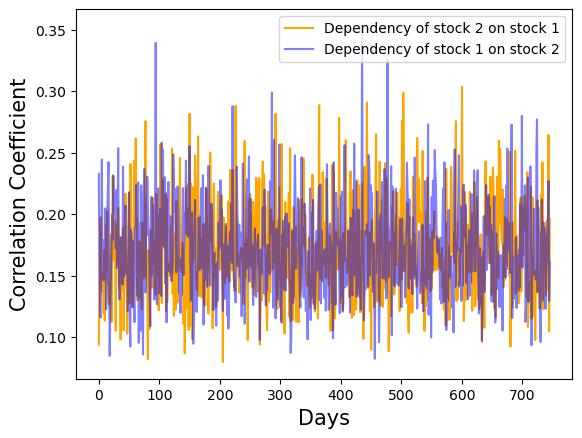

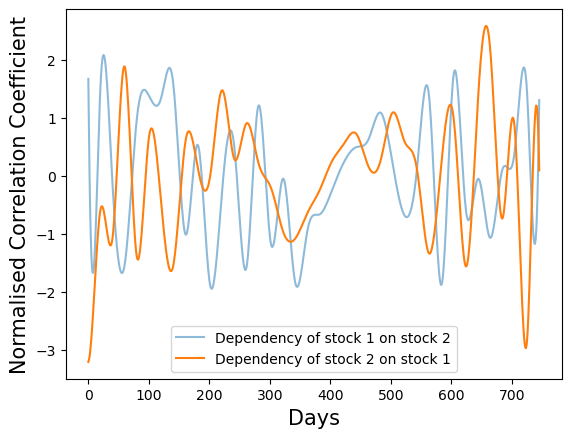

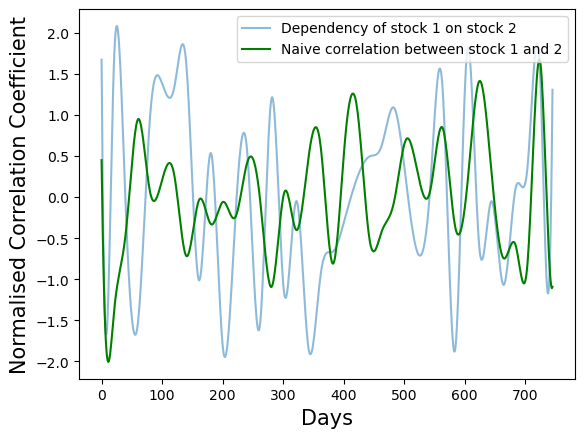

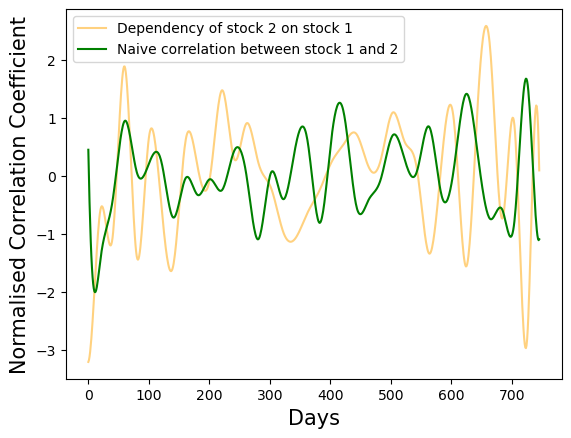

In [62]:
#plot the attention scores and normalised+smoothed attention scores between the first two stocks
#compare to naive method for calculating stock correlations
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

checkpoint = 1020
state_dict = torch.load(os.path.join(current_path, "..", "Network 1", "20-4-24", "Network2-2", "Checkpoints", "2checkpoint" + str(checkpoint) + ".pth"))
model.load_state_dict(state_dict)
with torch.no_grad():
    model.eval()
    inpt = []
    out = []
    for i in range(len(test_data)):
        x = test_data.inputs[i].unsqueeze(0)
        y = test_data.labels[i].unsqueeze(0)
        z = torch.transpose(x, 1, 2)
        market_index = z[:,0,:]
        market_index = torch.unsqueeze(market_index, 1)
        z = z[:, 1:]
        outputs = torch.mean(model(z, market_index)[1].squeeze(), dim=0)
        y = y[:, 1:]
        out.append(outputs)
        inpt.append(y.squeeze())

means = []
for i in range(len(out[0])):
    mean = np.mean([out[day][i][i] for day in range(len(out))])
    means.append(mean)   
    
print(means)

onetotwo = [out[day][0][1] for day in range(len(out))]
twotoone = [out[day][1][0] for day in range(len(out))]

plt.plot(twotoone, color = 'orange', label = 'Dependency of stock 2 on stock 1')
plt.plot(onetotwo, color='blue', alpha=0.5, label = 'Dependency of stock 1 on stock 2')
plt.xlabel("Days", fontsize=15)
plt.ylabel("Correlation Coefficient", fontsize=15)
plt.legend()
plt.show()

num_datapoints = 20
num_knots = max(0, math.floor(len(onetotwo)/num_datapoints-1))
time = np.arange(len(onetotwo))

knot_indices = np.linspace(num_datapoints, len(time) - 1-num_datapoints, num_knots).astype(int)
knots = time[knot_indices]

cs1 = LSQUnivariateSpline(time, onetotwo, k=3, t=knots)
smooth_prices1 = cs1(time)

cs2 = LSQUnivariateSpline(time, twotoone, k=3, t=knots)
smooth_prices2 = cs2(time)

smooth_prices1 = (smooth_prices1 - np.mean(smooth_prices1))/np.std(smooth_prices1)
smooth_prices2 = (smooth_prices2 - np.mean(smooth_prices2))/np.std(smooth_prices2)


plt.plot(smooth_prices1, alpha=0.5, label = 'Dependency of stock 1 on stock 2')
plt.plot(smooth_prices2, label = 'Dependency of stock 2 on stock 1')
plt.xlabel("Days", fontsize=15)
plt.ylabel("Normalised Correlation Coefficient", fontsize=15)
plt.legend()
plt.show()

stock1prices = test_data.inputs[:,:,1,3].squeeze()
stock2prices = test_data.inputs[:,:,2,3].squeeze()

correl = []
for day in range(len(stock1prices)):
    sum1 = 0
    for i in range(len(stock1prices[day])):
        if stock1prices[day][i] * stock2prices[day][i] > 0:
            sum1+=1
        else:
            sum1-=1
    correl.append(sum1)
    
correl = (correl - np.mean(correl))/np.std(correl)

num_datapoints = 20
num_knots = max(0, math.floor(len(correl)/num_datapoints-1))
time = np.arange(len(onetotwo))

knot_indices = np.linspace(num_datapoints, len(time) - 1-num_datapoints, num_knots).astype(int)
knots = time[knot_indices]

cs3 = LSQUnivariateSpline(time, correl, k=3, t=knots)
correl = cs3(time)

plt.plot(smooth_prices1, alpha = 0.5, label = 'Dependency of stock 1 on stock 2')
plt.plot(correl, color='green', label = "Naive correlation between stock 1 and 2")
plt.xlabel("Days", fontsize=15)
plt.ylabel("Normalised Correlation Coefficient", fontsize=15)
plt.legend()
plt.show()

plt.plot(smooth_prices2, color='orange', alpha = 0.5, label = 'Dependency of stock 2 on stock 1')
plt.plot(correl, color='green', label = "Naive correlation between stock 1 and 2")
plt.xlabel("Days", fontsize=15)
plt.ylabel("Normalised Correlation Coefficient", fontsize=15)
plt.legend()
plt.show()

In [63]:
#check the attention scores of each stock with itself
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

checkpoint = 1020
state_dict = torch.load(os.path.join(current_path, "..", "Network 1", "20-4-24", "Network2-2", "Checkpoints", "2checkpoint" + str(checkpoint) + ".pth"))
model.load_state_dict(state_dict)
with torch.no_grad():
    model.eval()
    inpt = []
    out = []
    for i in range(len(test_data)):
        x = test_data.inputs[i].unsqueeze(0)
        y = test_data.labels[i].unsqueeze(0)
        z = torch.transpose(x, 1, 2)
        market_index = z[:,0,:]
        market_index = torch.unsqueeze(market_index, 1)
        z = z[:, 1:]
        outputs = torch.mean(model(z, market_index)[1].squeeze(), dim=0)
        y = y[:, 1:]
        out.append(outputs)
        inpt.append(y.squeeze())

means = []
for i in range(len(out[0])):
    mean = np.mean([out[day][i][i] for day in range(len(out))])
    means.append(mean)   
    
print(means)

[0.31245685, 0.30870092, 0.31256542, 0.31452906, 0.31187415]
